In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard import notebook
import time
from datetime import datetime
import os

%load_ext tensorboard

# If using GPU, specify XLA_GPU_CUDA path (comment out otherwise)
# os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

# Disable GPU (faster on CPU for small models)
tf.config.set_visible_devices([], 'GPU')

# Options
tf.keras.backend.set_floatx('float32')
np.set_printoptions(precision=5, edgeitems=10, linewidth=1000, suppress=True)
tf.random.set_seed(0)
plt.rcParams.update({'font.size': 14})

In [4]:
# Parameters
sigma = 0.2
q = 1
a = 1
eps = 1.5
rho = 0.2
c = 1
T = 1
N_T = 50 # Number of subintervals on [0, T]
dt = 1/N_T # Time increment
N = 10 # Number of players
N_B = 100 # Batch size
x0 = tf.zeros((N))

# Get description of the game
desc = f'N={N},N_T={N_T}'

# Analytical solution - closed-loop equilibria:
R = (a+q)**2 + (1 - 1/N**2)*(eps-q)**2
delta_p = -(a+q) + np.sqrt(R)
delta_m = -(a+q) - np.sqrt(R)

def eta(t):
    """Compute eta at time t in the N-player game

    Args:
        t: Time

    Returns:
        eta
    """
    numerator = -(eps-q**2)*(np.exp((delta_p-delta_m)*(T-t))-1) - c*(delta_p*np.exp((delta_p - delta_m)*(T-t)) - delta_m)
    denominator = delta_m*np.exp((delta_p-delta_m)*(T-t))-delta_p - c*(1-1/N**2)*(np.exp((delta_p-delta_m)*(T-t)) - 1)
    return numerator/denominator

In [5]:
# Neural network architecture parameters
num_input_nodes = N+1
num_output_nodes = N

# Define a feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                768       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 5,578
Trainable params: 5,578
Non-trainable params: 0
_________________________________________________________________


In [189]:
@tf.function
def BMIncrements(N_B, N_T, N, antithetic=True, seed=False):
    """Precompute Brownian increments

    Args:
        N_B: Number of Brownian paths
        N_T: Number of time steps
        N: Number of players
        antithetic: Boolean on whether to include antithetic variates

    Returns:
        if antithetic==True: Brownian increments of shape (N_B, N_T, N), including antithetic variates 
        if antithetic==False: Brownian path of shape (N_T, N)
    """
    if seed:
        tf.random.set_seed(0)

    if antithetic == True:
        assert N_B%2 == 0, "Number of generated samples should be even if including antithetic variates"
        dat = tf.random.normal(shape=(N_B//2, N_T, N))*np.sqrt(dt)
        return tf.concat([dat, -dat], axis=0)
    else:
        return tf.squeeze(tf.random.normal(shape=(N_B, N_T, N))*np.sqrt(dt))

@tf.function
def simulate_paths(dW):
    """Simulate paths of the SDE with the control parameter alpha.

    Args:
        dW: (N_B, N_T, N+1) tensor of Brownian increments (first column of third dimension is common noise)
    
    Returns:
        x: (N_B, N_T+1, N) tensor of simulated paths
        alpha: (N_B, N_T, N) tensor of control parameters
    """
    t = tf.expand_dims(tf.constant([0], dtype=tf.float32), axis=1) # initial time
    x = []
    alpha = []
    x.append(tf.expand_dims(x0, axis=0))
    for i in range(1, N_T+1):
        alpha.append(model(tf.concat([t, x[i-1]], axis=1)))
        x.append(x[i-1] + a*((tf.math.reduce_mean(x[i-1]) - x[i-1]) + alpha[i-1])*dt + sigma*(rho*dW[i-1, 0] + (1-rho**2)**0.5*dW[i-1, 1:]))
        t = t + dt
    x = tf.squeeze(tf.stack(x))
    alpha = tf.squeeze(tf.stack(alpha))
    return x, alpha

@tf.function
def sde_euler(dW):
    """Simulate paths of the SDE without the control parameter alpha.
    
    Args:
        dW: (N_B, N_T, N+1) tensor of Brownian increments (first column of third dimension is common noise)
    
    Returns:
        x: (N_B, N_T+1, N) tensor of simulated paths
    """
    t = tf.expand_dims(tf.constant([0], dtype=tf.float32), axis=1) # initial time
    x = []
    x.append(tf.expand_dims(x0, axis=0))
    for i in range(1, N_T+1):
        x.append(x[i-1] + a*((tf.math.reduce_mean(x[i-1]) - x[i-1]))*dt + sigma*(rho*dW[i-1, 0] + (1-rho**2)**0.5*dW[i-1, 1:]))
        t = t + dt
    x = tf.squeeze(tf.stack(x))
    return x

def compute_analytic(dW):
    """Compute the analytical solution of the SDE.
    
    Args:
        dW: (N_B, N_T, N+1) tensor of Brownian increments (first column of third dimension is common noise)

    Returns:
        x: (N_B, N_T+1, N) array of the analytical solution
        alpha: (N_B, N_T, N) array of the analytical solution
    """
    X = np.zeros((N_T+1, N))
    alpha = np.zeros((N_T, N))
    t = 0
    for i in range(1, N_T+1):
        X_bar = np.mean(X[i-1], axis=0, keepdims=True)
        alpha[i-1] = (q + (1 - 1/N)*eta(t))*(X_bar-X[i-1])
        X[i] = X[i-1] + (a + q + (1 - 1/N)*eta(t))*(X_bar - X[i-1])*dt + sigma*(rho*dW[i-1, 0] + (1-rho**2)**0.5*dW[i-1, 1:])
        t = t + dt
    return X, alpha

def compute_cost(X, alpha):
    """Compute the cost function for the SDE control problem.

    Args:
        X (tf.Tensor): The simulated dynamics of the system.
        alpha (tf.Tensor): The control parameter.
    """

    X_T = X[N_T][None, :]
    X = X[:N_T]
    X_T_bar = tf.reduce_mean(X_T, axis=1, keepdims=True)
    X_bar = tf.reduce_mean(X, axis=1, keepdims=True)

    # Compute the running cost
    running_cost = 0.5*alpha**2 - q*alpha*(X_bar-X) + 0.5*eps*(X_bar-X)**2

    # Compute the terminal cost
    terminal_cost = 0.5*c*(X_T_bar-X_T)**2

    # Compute the total cost
    costs = tf.concat([running_cost, terminal_cost], axis=0)
    total_cost = tf.reduce_sum(costs, axis=0)

    return total_cost

def simulate(N_B, N_T, N):
    """Simulate forward from t0, X0 and return total loss

    Args:
        S: Training data

    Returns:
        total_cost: Average total cost for each player and batch
    """
    # Pre-compute Brownian paths
    BM = BMIncrements(N_B, N_T, N+1)

    # Simulate paths and control
    X, alpha = tf.map_fn(simulate_paths, BM, fn_output_signature=(tf.float32, tf.float32))

    # Compute total cost
    total_cost = tf.map_fn(lambda x: compute_cost(x[0], x[1]), (X, alpha), fn_output_signature=tf.float32)
    total_cost = tf.reduce_mean(total_cost)

    return total_cost

In [7]:
# Hyper-parameters
lr = 1e-4

optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)
model.compile(optimizer)

In [8]:
@tf.function(jit_compile=True)
def train_step():
    """Train step

    Returns:
        Loss value
    """

    # Automatic differentiation
    with tf.GradientTape() as tape:

        # Forward pass of the model to get total cost
        loss_value = simulate(N_B, N_T, N)             

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

In [9]:
def training_algorithm(num_epochs):

    # Initialise metrics to get mean loss per epoch
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()
          
        # Training step
        loss_value = train_step()      
                        
        # Update the metrics per epoch
        epoch_loss_metric.update_state(loss_value)              
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}: log10(loss): {tf.experimental.numpy.log10(epoch_mean_loss):.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

In [12]:
%tensorboard --logdir logs/gradient_tape --host localhost

Reusing TensorBoard on port 6006 (pid 40980), started 0:05:44 ago. (Use '!kill 40980' to kill it.)

In [11]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '-' + desc
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
with train_summary_writer.as_default():
    training_algorithm(1001)

Instructions for updating:
Use fn_output_signature instead
Epoch 0: log10(loss): -0.21058
Epoch 100: log10(loss): -0.41522
Epoch 200: log10(loss): -0.54899
Epoch 300: log10(loss): -0.64656
Epoch 400: log10(loss): -0.78677
Epoch 500: log10(loss): -0.86598
Epoch 600: log10(loss): -0.99914
Epoch 700: log10(loss): -0.99891
Epoch 800: log10(loss): -1.02014
Epoch 900: log10(loss): -1.04558
Epoch 1000: log10(loss): -1.02430
Training took 00:05:26


In [15]:
# model.save_weights(f'./weights/' + desc)

In [14]:
# model.load_weights(f'./weights/' + desc)

# Plots

In [149]:
def plot_solution(k=N):
    """Plot deep learning solution
    
    Args:
        k: Number of players to plot, integer. Defaults to N.
    """

    assert type(k) == int, "k must be an integer less than or equal to N"
    assert k <= N, "k must not exceed N"

    idx = random.sample(range(N), k=k)

    # Compute estimated and analytical solutions
    BMPath = BMIncrements(1, N_T, N+1, antithetic=False, seed=True)
    X, alpha = simulate_paths(BMPath)
    X_analytic, alpha_analytic = compute_analytic(BMPath)
    X = X.numpy()
    alpha = alpha.numpy()
    # X_bar = np.mean(X, axis=1, keepdims=True)

    with sns.color_palette(n_colors=k):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        fig.set_facecolor('white')

        ax1.set_title(r"Dynamics, $X$")
        ax1.plot(np.arange(start=0, stop=T+dt, step=dt), X[:, idx], linestyle='dashed', label='Estimated')
        ax1.plot(np.arange(start=0, stop=T+dt, step=dt), X_analytic[:, idx], label='Analytic')
        ax1.set_xlabel("t")
        handles, labels = ax1.get_legend_handles_labels()
        labels, ids = np.unique(labels, return_index=True)
        handles = [handles[i] for i in ids]
        ax1.legend(handles, labels, loc='best')

        ax2.set_title(r"Control, $\alpha$")
        ax2.plot(np.arange(start=0, stop=T, step=dt), alpha[:, idx], linestyle='dashed', label='Estimated')
        ax2.plot(np.arange(start=0, stop=T, step=dt), alpha_analytic[:, idx], label='Analytic')
        ax2.set_xlabel("t")
        handles, labels = ax2.get_legend_handles_labels()
        labels, ids = np.unique(labels, return_index=True)
        handles = [handles[i] for i in ids]
        ax2.legend(handles, labels, loc='best')

    plt.show()

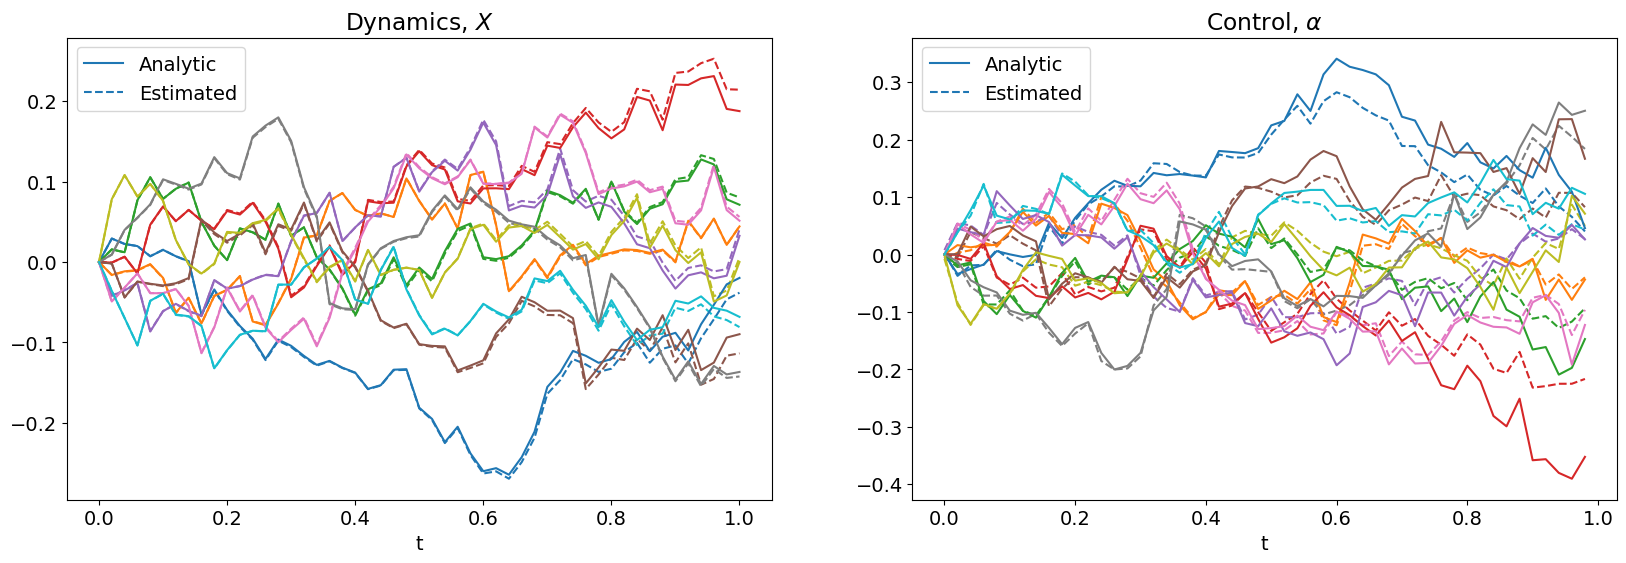

In [150]:
plot_solution(N)

In [203]:
def plot_loss(N_S, default_level):
    """Plot the loss distribution
    
    Args:
        N_B (int): Number of simulations
        default_level (float): Default level
    """
    # Pre-compute Brownian paths
    BM = BMIncrements(N_S, N_T, N+1)

    # Simulate paths with and without control
    X, _ = tf.map_fn(simulate_paths, BM, fn_output_signature=(tf.float32, tf.float32))
    X = X.numpy()
    Y = tf.map_fn(sde_euler, BM, fn_output_signature=tf.float32).numpy()

    # Compute number of defaults per simulation
    defaults_X = np.sum(tf.math.reduce_min(X, axis=1) <= default_level, axis=1)
    defaults_Y = np.sum(tf.math.reduce_min(Y, axis=1) <= default_level, axis=1)

    # Get frequency table of the number of defaults
    table_X = np.array([np.arange(N+1), np.bincount(defaults_X, minlength=N+1)/N_S])
    table_Y = np.array([np.arange(N+1), np.bincount(defaults_Y, minlength=N+1)/N_S])

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.set_facecolor('white')

    ax1.set_title("Loss distribution with control")
    ax1.plot(table_X[0], table_X[1])
    ax1.set_xlabel("Number of defaults")
    ax1.set_ylabel("Probability")
    ax1.set_ylim(0, 0.2)

    ax2.set_title("Loss distribution without control")
    ax2.plot(table_Y[0], table_Y[1])
    ax2.set_xlabel("Number of defaults")
    ax2.set_ylabel("Probability")
    ax2.set_ylim(0, 0.2)

    plt.show()

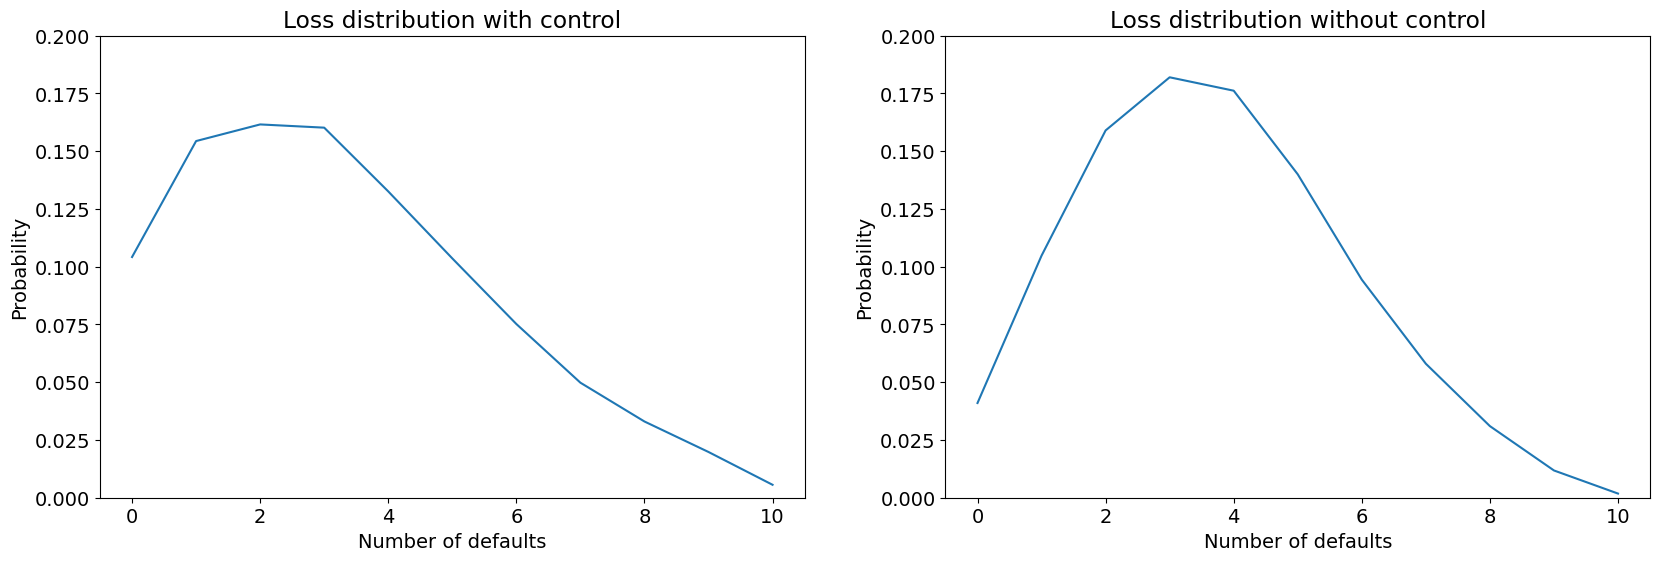

In [205]:
plot_loss(5000, -0.15)